# Fitting spatially resolved SEDs with Dense Basis

In this step, we will use [Dense Basis](https://dense-basis.readthedocs.io/en/latest/) (called within `piXedfit_fitting` module) for fitting the SED of all spatial bins and then construct maps of physical properties. 

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import dense_basis as db
from astropy.io import fits

print('DB version: ',db.__version__)

%matplotlib inline

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.
DB version:  0.1.9


### Call `dense_basis_SEDfit` class

In [2]:
from piXedfit.piXedfit_fitting import dense_basis_SEDfit

In [3]:
fits_binmap = 'pixbin_fluxmap_whl0137_z2.fits'
dbfit = dense_basis_SEDfit(fits_binmap)

### Take filter transmission curves from the binned data cube and store them into text files

This will be used in generating basis model templates by Dense Basis

In [4]:
filter_list, filt_dir, gal_z, nbins = dbfit.filter_curves_txt_from_binmap()

### Define priors and generate model atlas within Dense Basis 

In [6]:
# Priors class, to see all the options look in the priors.py file in the dense_basis folder
priors = db.Priors()
priors.mass_min = 5.
priors.mass_max = 12.

# SFH priors
priors.Nparam = 3
priors.tx_alpha = np.ones((priors.Nparam+1,))*5.0
priors.tx_alpha[0] = 12.
# priors.tx_alpha[1] = 5.
# added this for v2
# priors.tx_alpha[0] = 22.

# SFR prior
priors.sfr_prior_type = 'sSFRlognormal'
priors.dynamic_decouple = True

# metallicity prior
priors.met_treatment = 'flat'
priors.Z_min = -2.0
priors.Z_max = 0.3

# dust prior
priors.dust_prior = 'exp'
# priors.Av_exp_scale = 1.0
priors.Av_min = 0
priors.Av_max = 4 

# redshift prior
zval, zbw = gal_z, 0.05
priors.z_min = zval-zbw
priors.z_max = zval+zbw

fname = 'atlas'
N_pregrid = 20000
path = 'pregrids/'

In [6]:
db.generate_atlas(N_pregrid=N_pregrid, priors=priors, fname=fname, 
                  store=True, path=path, filter_list=filter_list, filt_dir=filt_dir)

generating atlas with: 
3  tx parameters,  sSFRlognormal  SFR sampling custom  SFH treatment flat  met sampling Calzetti  dust attenuation exp  dust prior False  SFR decoupling.


100%|██████████| 20000/20000 [17:27<00:00, 19.09it/s]


Path exists. Saved atlas at : pregrids/atlas_20000_Nparam_3.dbatlas


### Run SED fitting to all spatial bins

In [7]:
binid_range = None  # set to None means all spatial bins will be fit
fits_dir = 'fits/'  # directory to store fitting results
dbfit.SEDfit_bins(priors, fname, N_pregrid=N_pregrid, path=path, binid_range=binid_range, 
                  make_plots=True, fits_dir=fits_dir)

Both bin_ids and binid_range are empty, so SED fitting will be done to all the bins.


## Construct maps of properties from the fitting results of all spatial bins 

In [14]:
bin_ids = []
name_sampler_fits = []
for bb in range(nbins):
    name = 'db_bin%d.fits' % (bb+1)
    if os.path.exists(fits_dir+'/'+name) == True:
        bin_ids.append(bb)
        name_sampler_fits.append(name)

fits_fluxmap = 'fluxmap_whl0137_z2.fits'
name_out_fits = 'maps_properties_whl0137_z2.fits'
dbfit.construct_maps_parameters(bin_ids,name_sampler_fits,fits_dir,fits_fluxmap,
                                refband_SFR=3,refband_SM=11,name_out_fits=name_out_fits)

'maps_properties_whl0137_z2.fits'

### Plot maps of properties

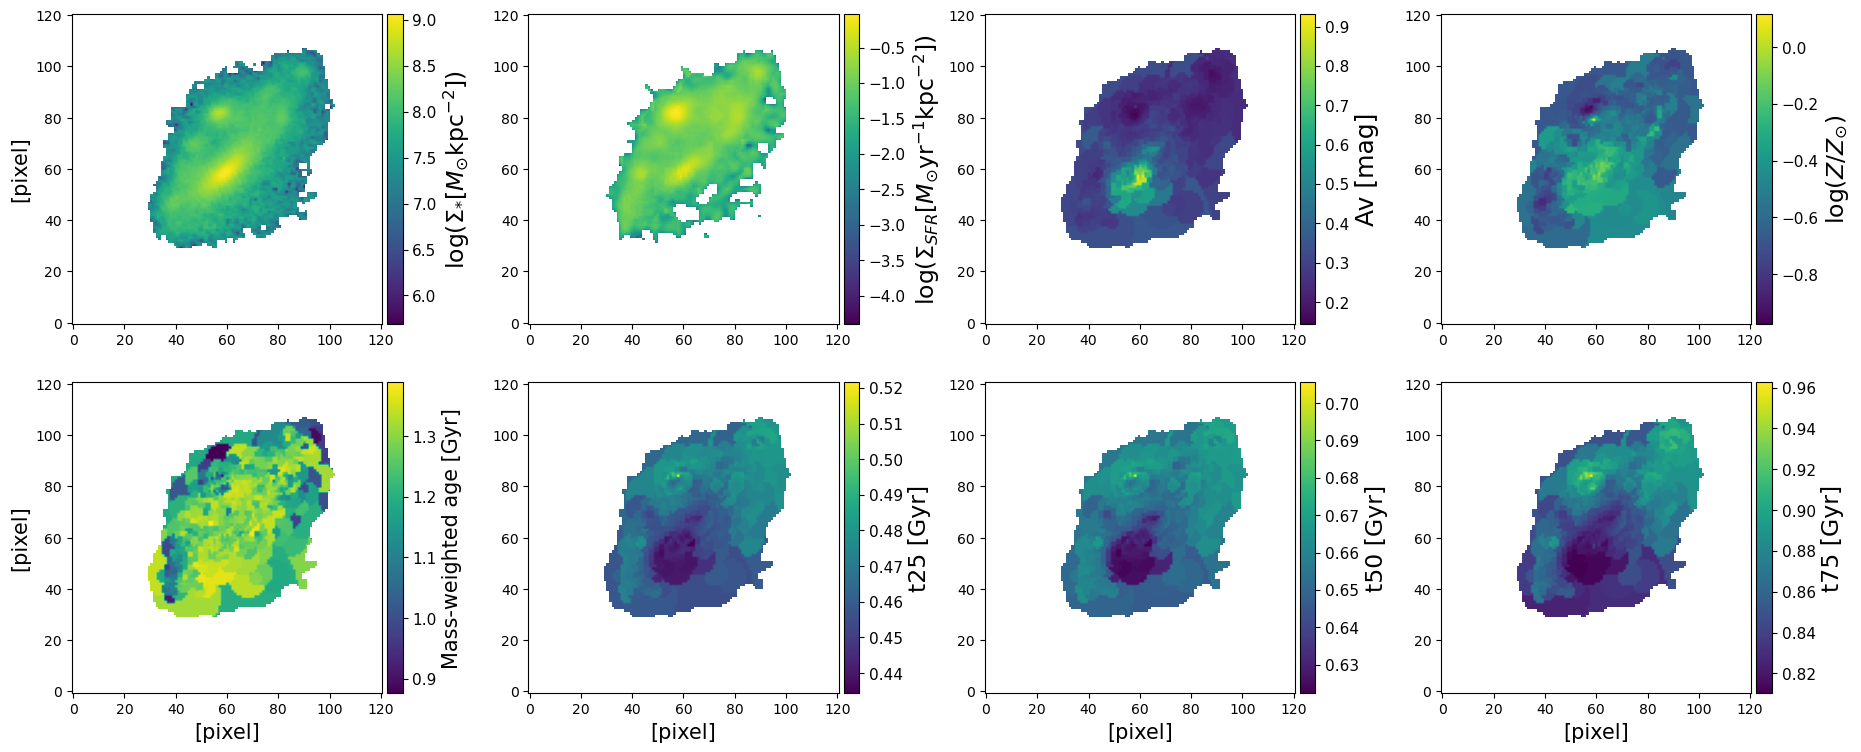

In [7]:
%matplotlib inline

fits_map_params = 'maps_properties_whl0137_z2.fits'
dbfit.plot_maps_properties(fits_map_params, params=None, ncols=4)
plt.savefig('maps_properties_whl0137_z2.png', bbox_inches = 'tight')